In [ ]:
#SOURCE: https://www.kaggle.com/code/databeru/fish-classifier-grad-cam-viz-acc-99-89/notebook

In [4]:
#imports
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 

In [32]:
image_dir = Path('../classifier/Fish_Dataset/')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [33]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,..\classifier\Fish_Dataset\Red Mullet\Red Mull...,Red Mullet
1,..\classifier\Fish_Dataset\Black Sea Sprat\Bla...,Black Sea Sprat
2,..\classifier\Fish_Dataset\Sea Bass\Sea Bass\0...,Sea Bass


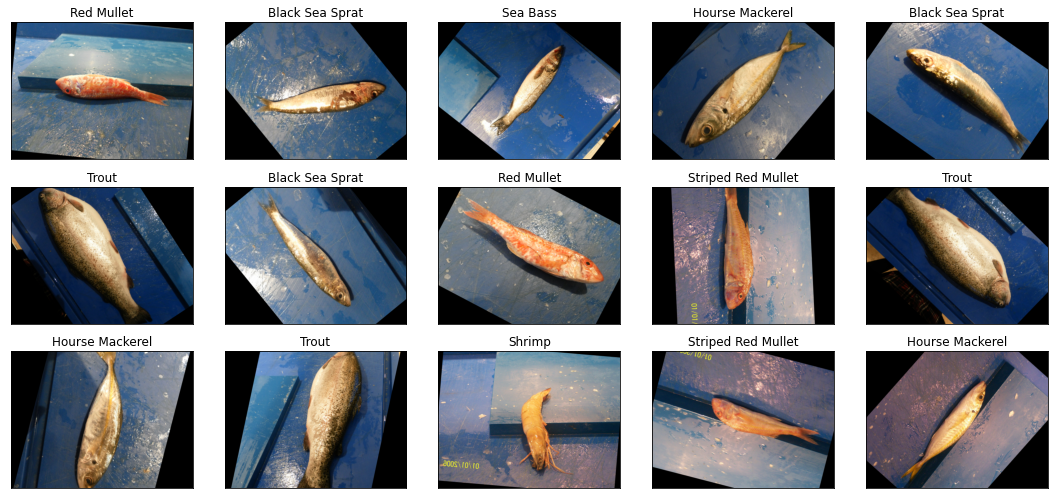

In [34]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [35]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [36]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [37]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [38]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [39]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
203/203 [==============================] - 87s 398ms/step - loss: 0.1992 - accuracy: 0.9395 - val_loss: 0.0224 - val_accuracy: 0.9944
Epoch 2/50
203/203 [==============================] - 50s 247ms/step - loss: 0.0069 - accuracy: 0.9995 - val_loss: 0.0115 - val_accuracy: 0.9957
Epoch 3/50
203/203 [==============================] - 51s 251ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9981
Epoch 4/50
203/203 [==============================] - 52s 259ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0040 - val_accuracy: 0.9988
Epoch 5/50
203/203 [==============================] - 52s 258ms/step - loss: 5.6242e-04 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9994
Epoch 6/50
203/203 [==============================] - 53s 259ms/step - loss: 3.5658e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9988
Epoch 7/50
203/203 [==============================] - 53s 261ms/step - loss: 2.6191e-04 - accuracy: 1.0000 - val_loss: 0.0

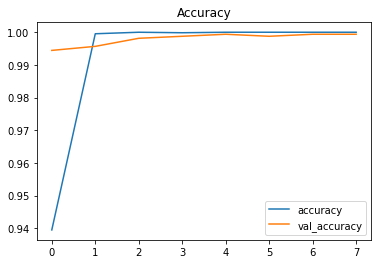

In [40]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

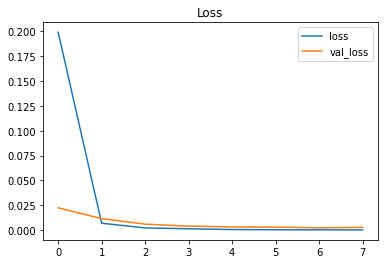

In [41]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [42]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00512
Test Accuracy: 99.89%


In [43]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

29/29 [==============================] - 6s 198ms/step
The first 5 predictions: ['Striped Red Mullet', 'Black Sea Sprat', 'Red Mullet', 'Striped Red Mullet', 'Red Sea Bream']


In [66]:
# Saving the model for later usage

model.save('../classifier/')

INFO:tensorflow:Assets written to: ../classifier/assets


INFO:tensorflow:Assets written to: ../classifier/assets


In [44]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       104
   Gilt-Head Bream       1.00      1.00      1.00       105
   Hourse Mackerel       1.00      1.00      1.00        96
        Red Mullet       1.00      0.99      0.99        94
     Red Sea Bream       1.00      1.00      1.00        91
          Sea Bass       1.00      1.00      1.00       109
            Shrimp       1.00      1.00      1.00        75
Striped Red Mullet       0.99      1.00      1.00       113
             Trout       1.00      1.00      1.00       113

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



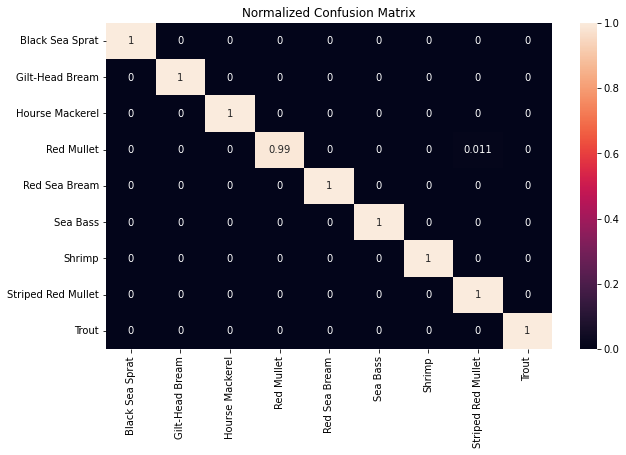

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

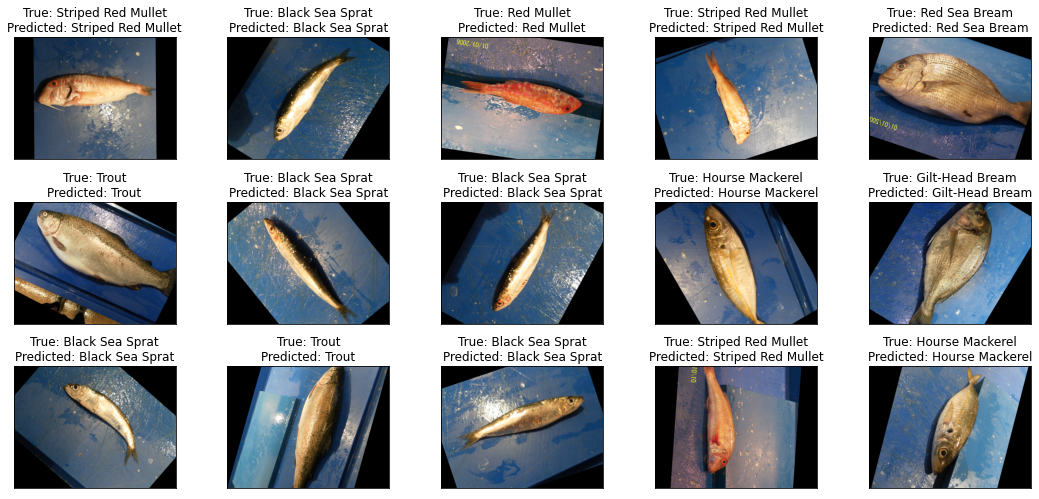

In [46]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [69]:
# Loading in some different test data downloaded from Google

image_dir = Path('../classifier/Test_images/')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
testi_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
testi_df = testi_df[testi_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [70]:
# Shuffle the DataFrame and reset index
testi_df = testi_df.sample(frac=1).reset_index(drop = True)

# Show the result
testi_df.head(3)

,Filepath,Label
0,..\classifier\Test_images\Kuha\1.png,Kuha
1,..\classifier\Test_images\Hauki\2.png,Hauki
2,..\classifier\Test_images\Kuha\2.png,Kuha


SyntaxError: not a PNG file (<string>)

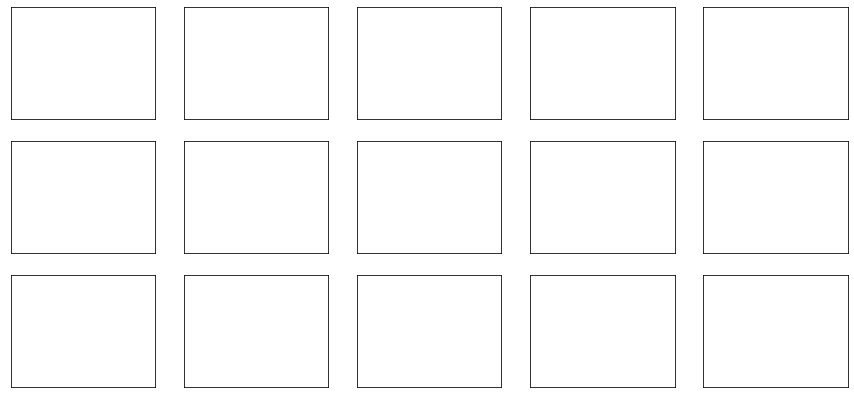

In [71]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testi_df.Filepath[i]))
    ax.set_title(testi_df.Label[i])
plt.tight_layout()
plt.show()

SyntaxError: not a PNG file (<string>)

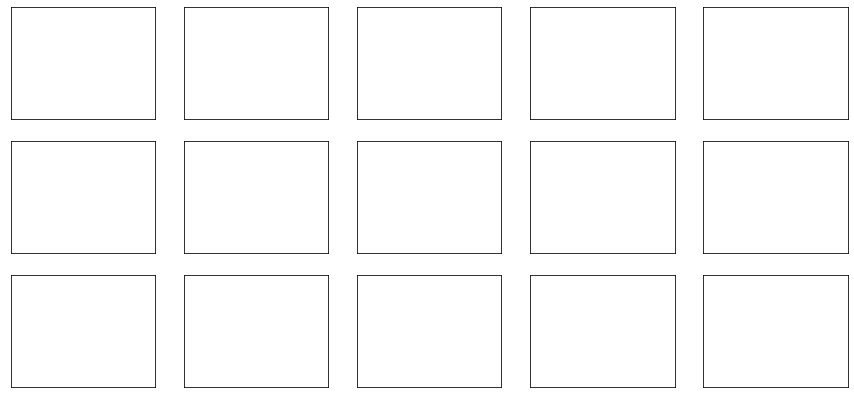

In [72]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testi_df.Filepath.iloc[i]))
    ax.set_title(f"True: {testi_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()